In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
!pip install country_converter
import country_converter as coco
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.9 MB/s eta 0:00:00


In [3]:
df = pd.read_csv('/kaggle/input/data-science-salaries-2023/ds_salaries.csv')
print(df.shape)
df.head()

(3755, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [4]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [5]:
df.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [6]:
df['Country_Grouped'] = df['employee_residence'].apply(lambda x: x if x in ['US', 'GB', 'CA', 'ES', 'IN'] else 'Others')
df['Company_Grouped'] = df['company_location'].apply(lambda x: x if x in ['US', 'GB', 'CA', 'ES', 'IN'] else 'Others')
df['Salary_Grouped'] = df['salary_currency'].apply(lambda x: x if x in ['USD', 'EUR', 'GBP', 'INR', 'CAD'] else 'Others')

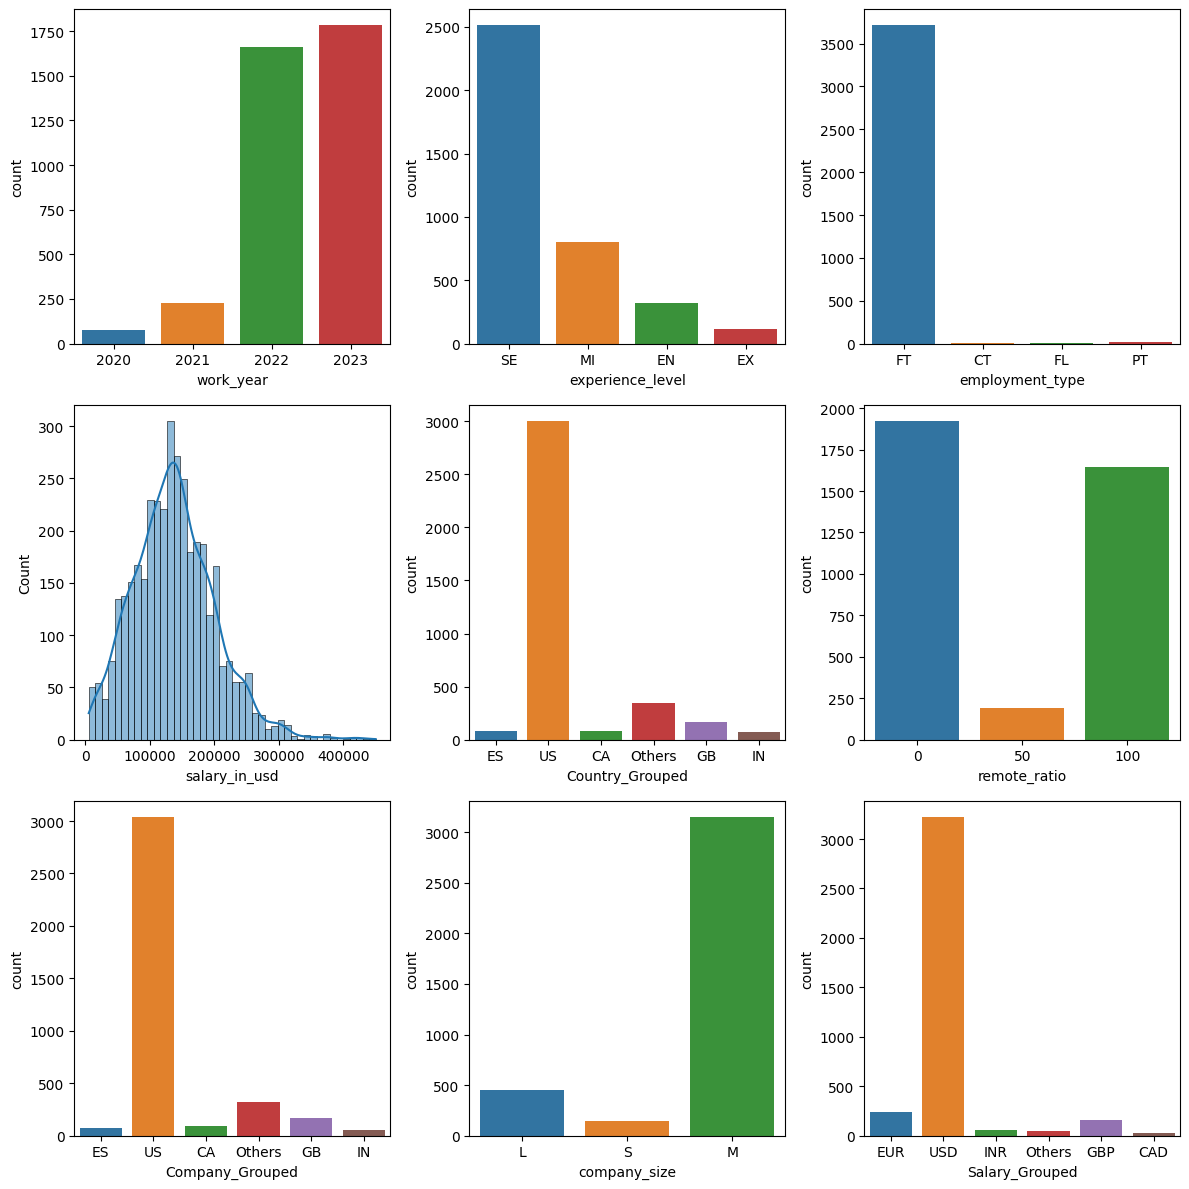

In [7]:
# take a look at distributed data
fig, ax = plt.subplots(3,3, figsize=(12,12))
sns.countplot(df, x='work_year', ax=ax[0,0])
sns.countplot(df, x='experience_level', ax=ax[0,1])
sns.countplot(df, x='employment_type', ax=ax[0,2])
sns.histplot(df, x='salary_in_usd', kde=True, ax=ax[1,0])
sns.countplot(df, x='Country_Grouped', ax=ax[1,1])
sns.countplot(df, x='remote_ratio', ax=ax[1,2])
sns.countplot(df, x='Company_Grouped', ax=ax[2,0])
sns.countplot(df, x='company_size', ax=ax[2,1])
sns.countplot(df, x='Salary_Grouped', ax=ax[2,2])
plt.tight_layout()

**Let's take a look at salary distribution.**  
The majority of salaries are clustered around the lower end, roughly between 25,000 and   75,000.  
There are fewer data points as the salary increases, indicating that higher salaries are less common in the dataset.

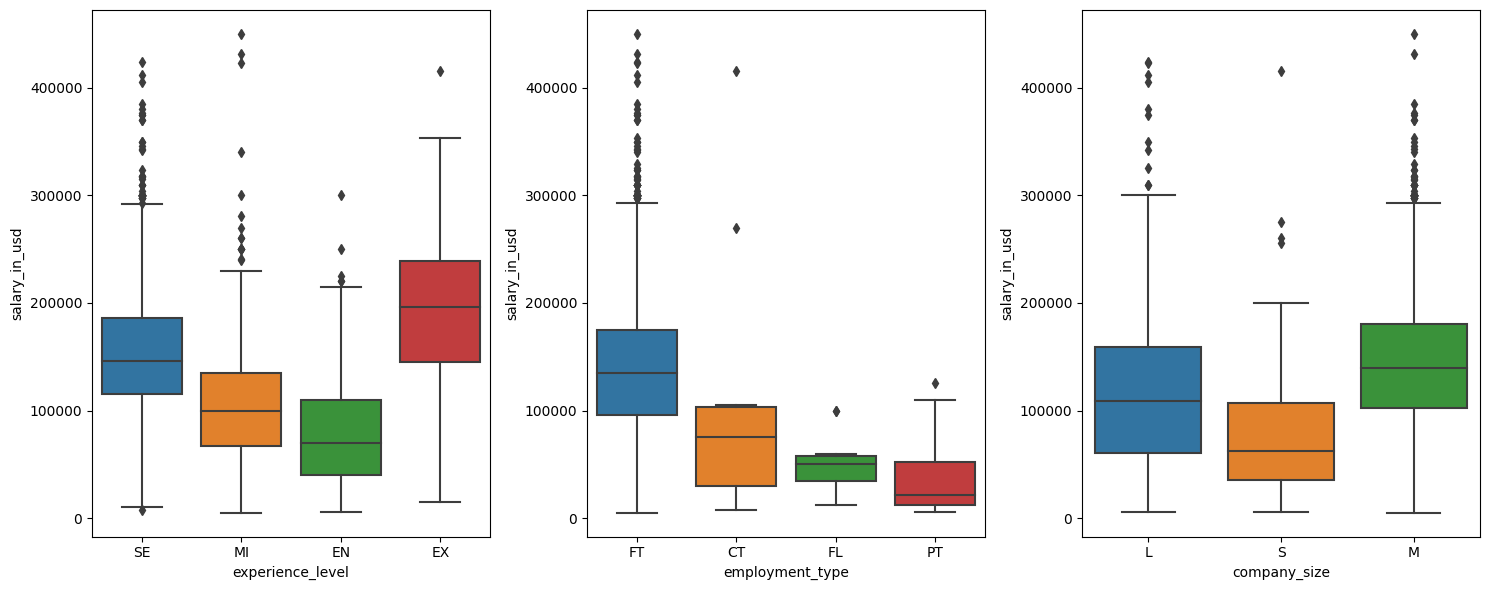

In [8]:
# let's explore the relationship between feature and salary
fig, ax = plt.subplots(1,3, figsize=(15,6))
sns.boxplot(df, y='salary_in_usd', x='experience_level', ax=ax[0])
sns.boxplot(df, y='salary_in_usd', x='employment_type', ax=ax[1])
sns.boxplot(df, y='salary_in_usd', x='company_size', ax=ax[2])
plt.tight_layout()

1. Experience Level vs Salary: The boxplot shows that higher experience levels generally correspond to higher median salaries. The distribution also tends to have a wider range at higher experience levels.

2. Employment Type vs Salary: Full-time roles generally have higher salaries compared to contract roles. However, the variance in full-time salaries is also larger.

3. Company Size vs Salary: The size of the company doesn't show a very clear trend in relation to salary based on the boxplot.

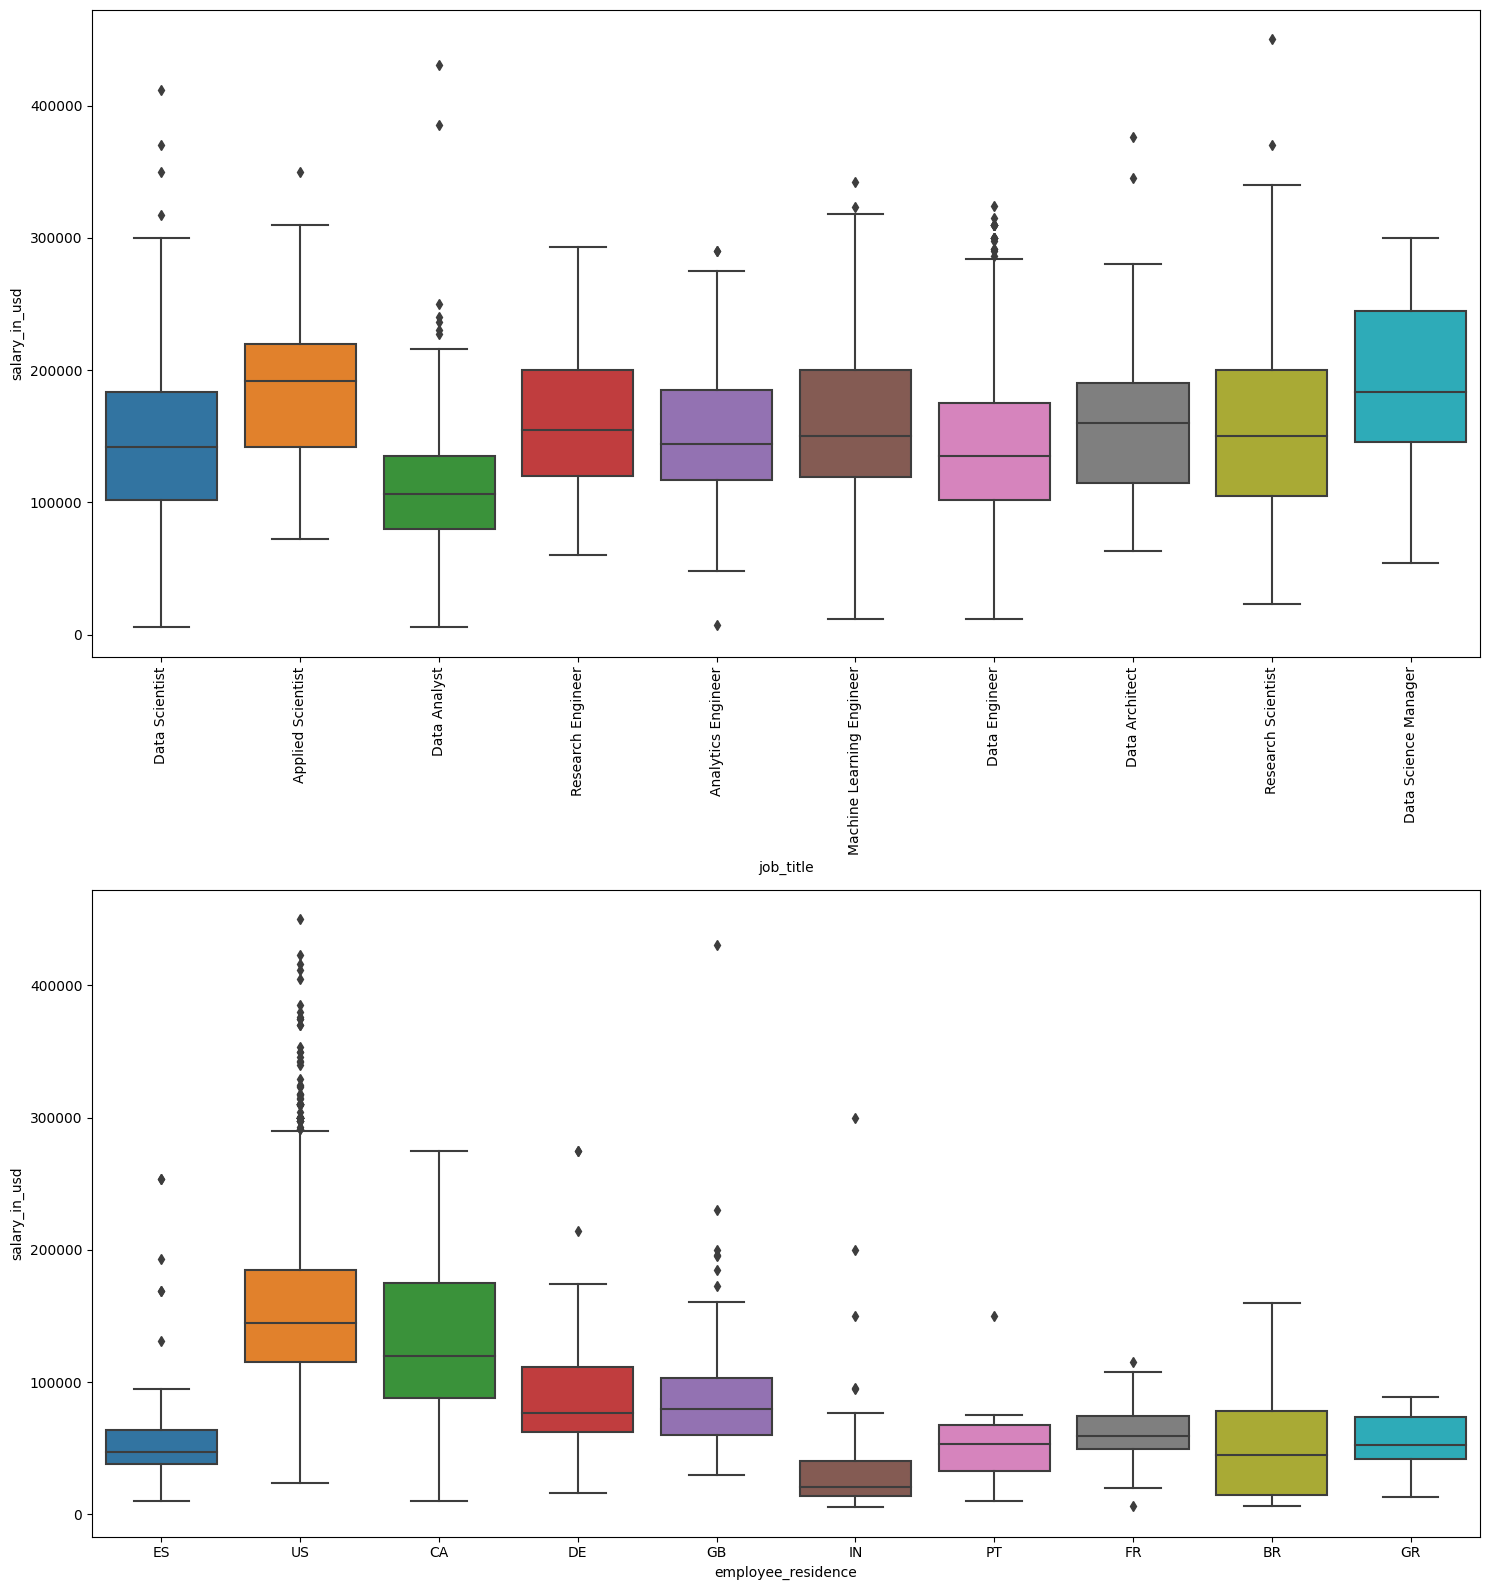

In [9]:
# top 10 job title and region
top_10_job_list = df['job_title'].value_counts().head(10).index.tolist()
df_top_10_job = df[df['job_title'].isin(top_10_job_list)]
top_10_residence_list = df['employee_residence'].value_counts().head(10).index.tolist()
df_top_10_residence = df[df['employee_residence'].isin(top_10_residence_list)]
fig, ax = plt.subplots(2,1,figsize=(15,16))
sns.boxplot(df_top_10_job, x='job_title', y='salary_in_usd', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)
sns.boxplot(df_top_10_residence, x='employee_residence', y='salary_in_usd', ax=ax[1])
plt.tight_layout()

* Each box represents the interquartile range (IQR) of salaries for a specific job title, giving you an idea of the spread of salaries for that role.  
* The line inside each box marks the median salary for that job title.  
* The "whiskers" extend to 1.5 times the IQR, and points outside of these whiskers are considered outliers.

<Axes: xlabel='employee_residence', ylabel='Count'>

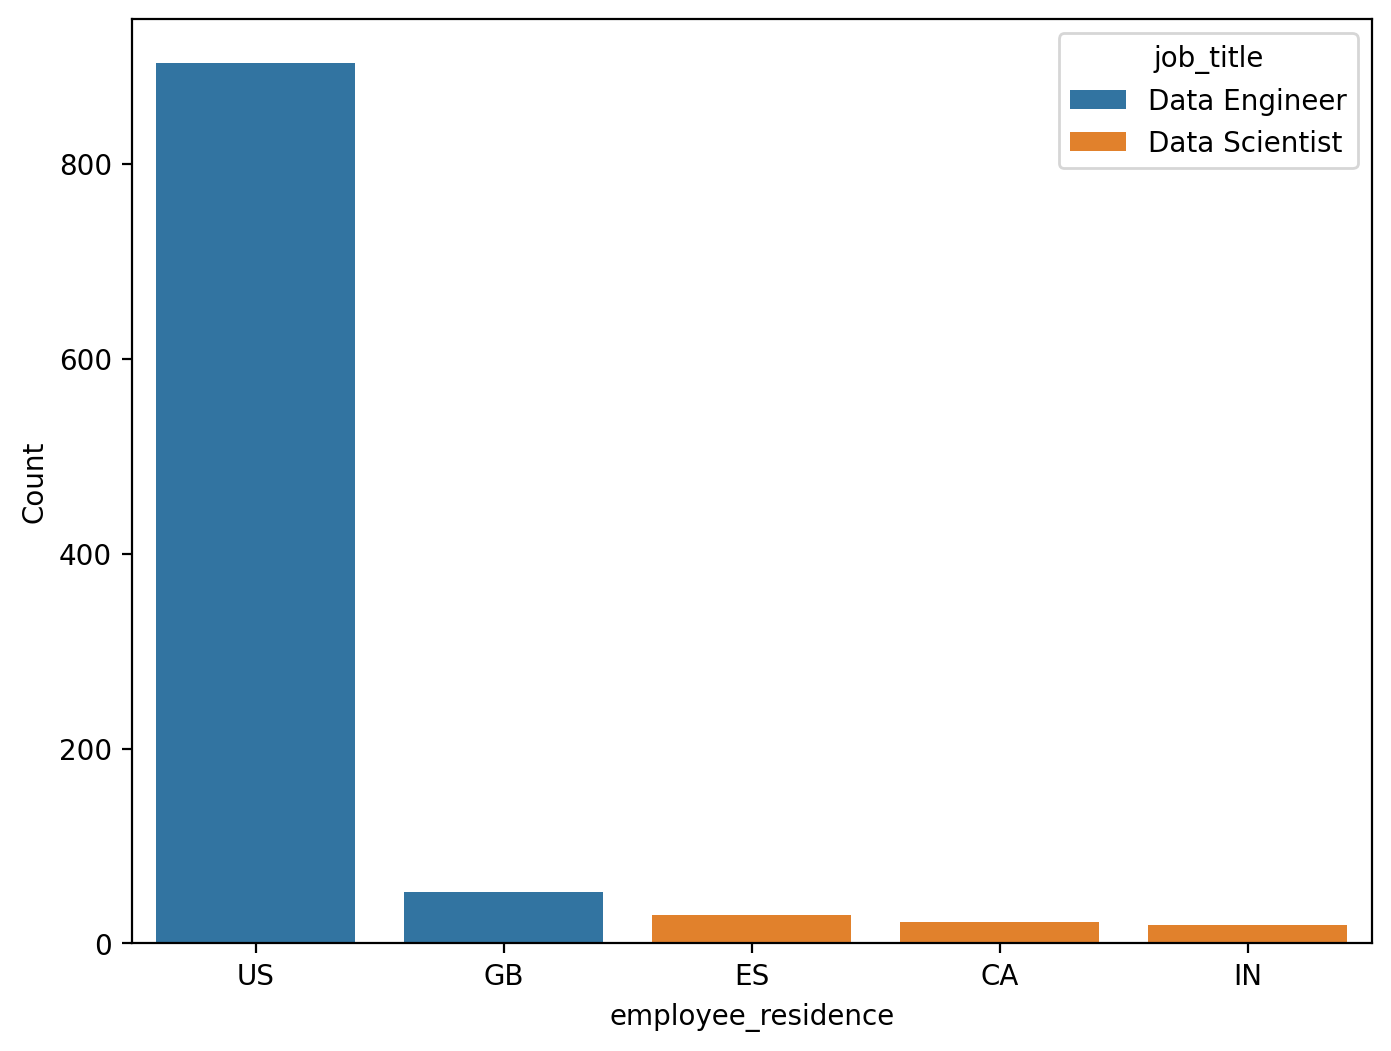

In [10]:
# explore the most common job title for each region 
job_title_by_region = df.groupby(['employee_residence','job_title']).size().reset_index(name='Count')
most_job_title_by_region = job_title_by_region.loc[job_title_by_region.groupby('employee_residence')['Count'].idxmax()]
top_5_region = most_job_title_by_region.nlargest(5, 'Count')
plt.figure(figsize=(8,6), dpi=200)
sns.barplot(data=top_5_region, x='employee_residence', y='Count', hue='job_title', dodge=False)

In the United States (US), the most common job title is "Data Engineer" with 903 occurrences.
In the United Kingdom (GB), the most common job title is also "Data Engineer," but with 53 occurrences.
In Spain (ES) and Canada (CA), the most common job title is "Data Scientist" with 29 and 22 occurrences, respectively.
In India (IN), the most common job title is "Data Scientist" with 19 occurrences.

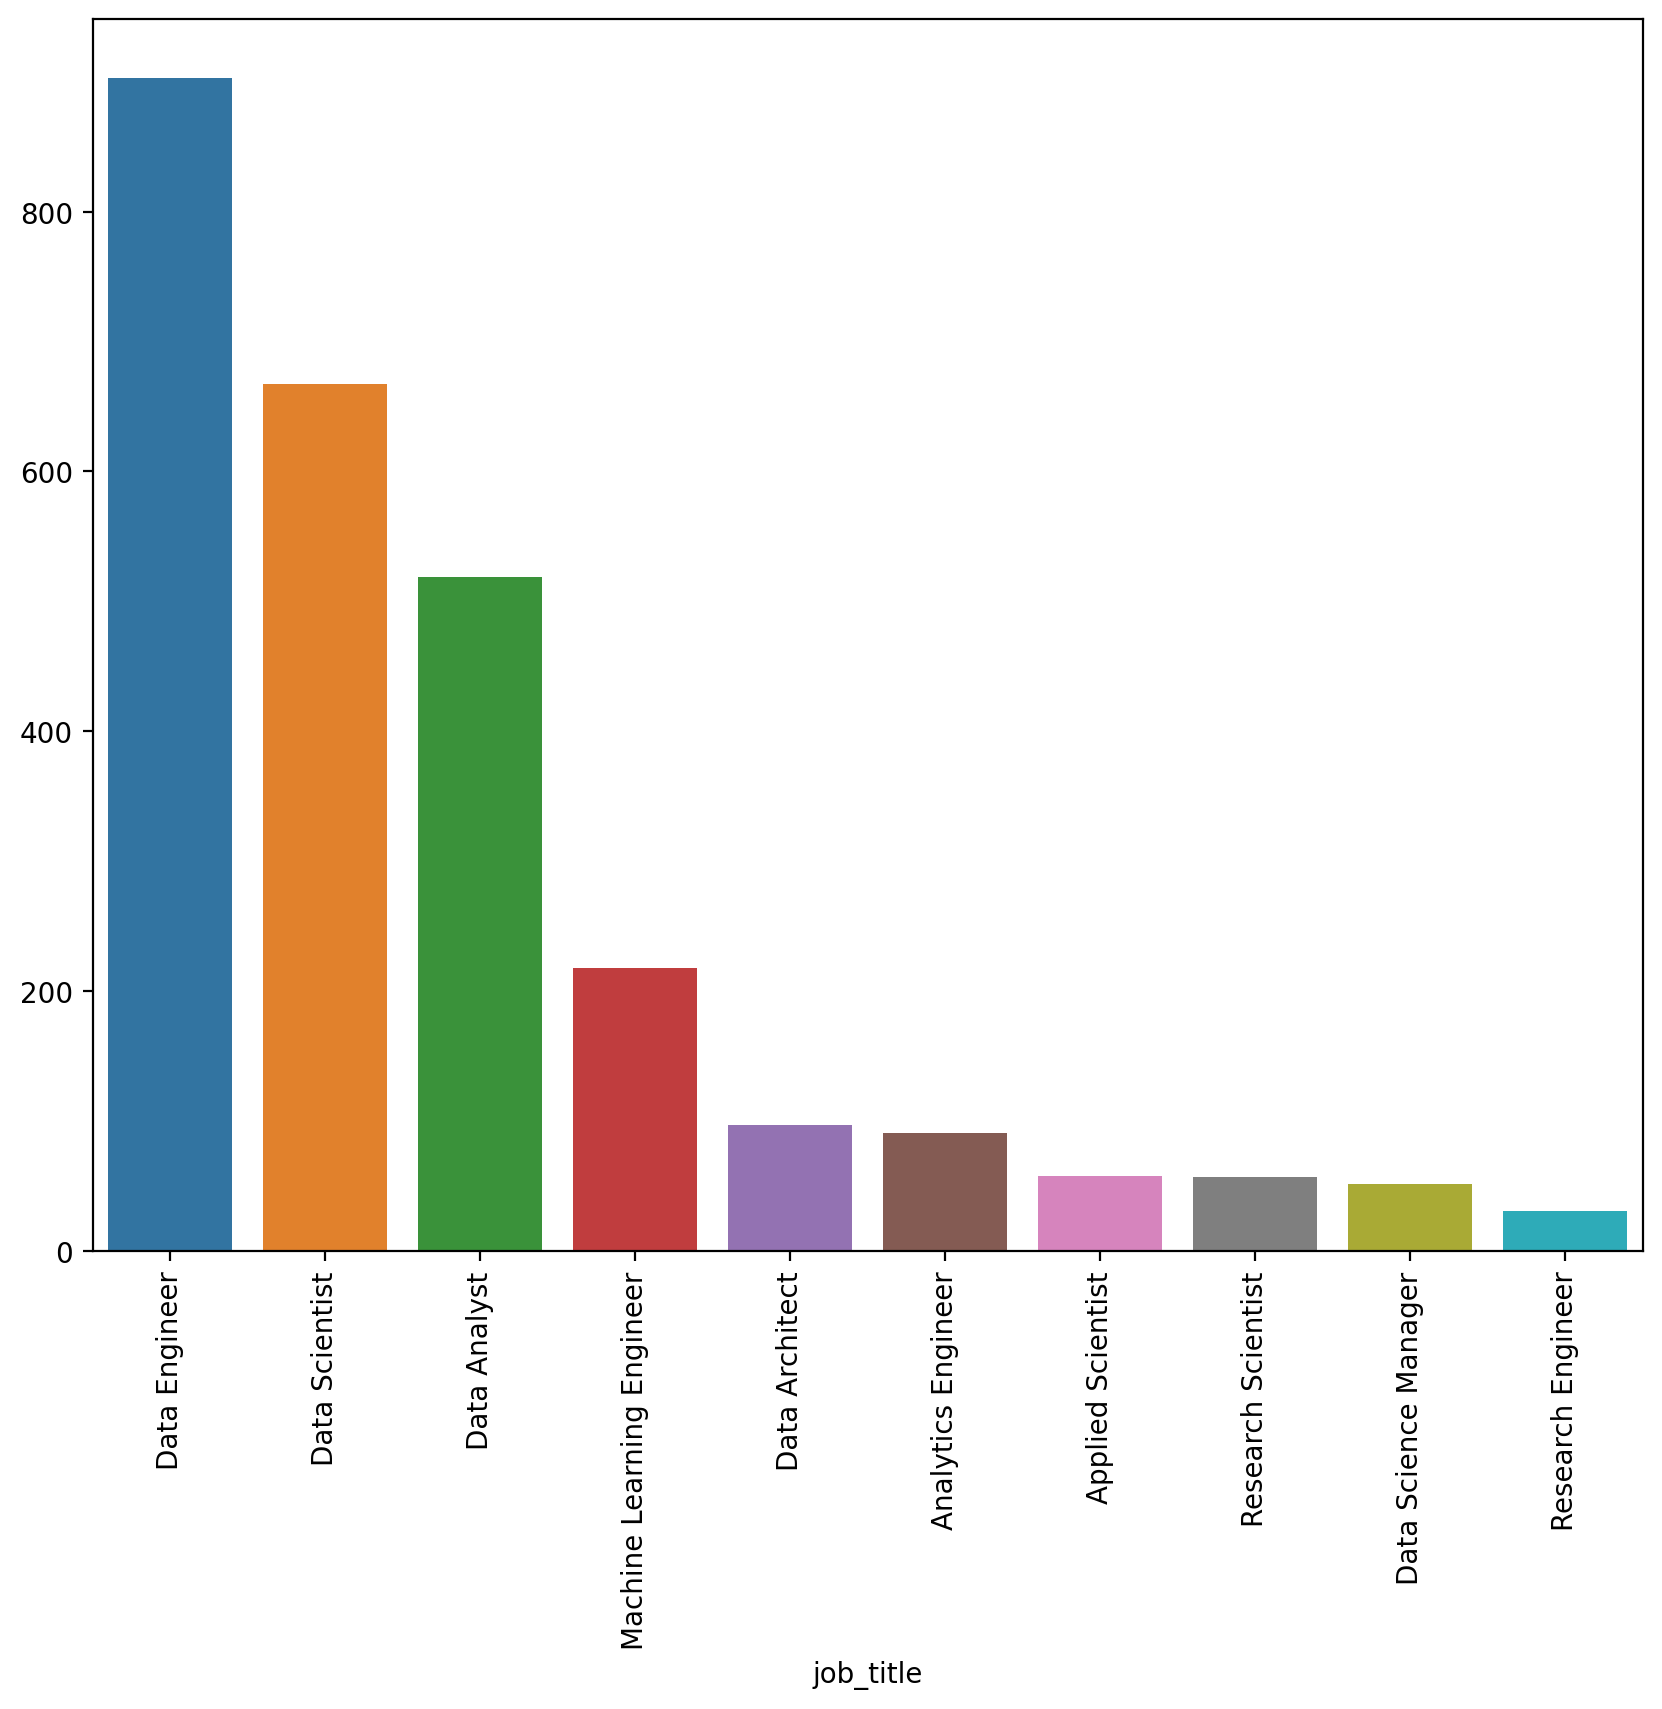

In [11]:
# deep explore us job
us_job_title = df[df['employee_residence'] == 'US'].groupby('job_title').count()['work_year'].sort_values(ascending=False).head(10)
plt.figure(figsize=(10,8), dpi=200)
sns.barplot(x=us_job_title.index, y=us_job_title.values)
plt.xticks(rotation=90);

The visualization and table present the top 10 most common job titles along with their median salary in USD:

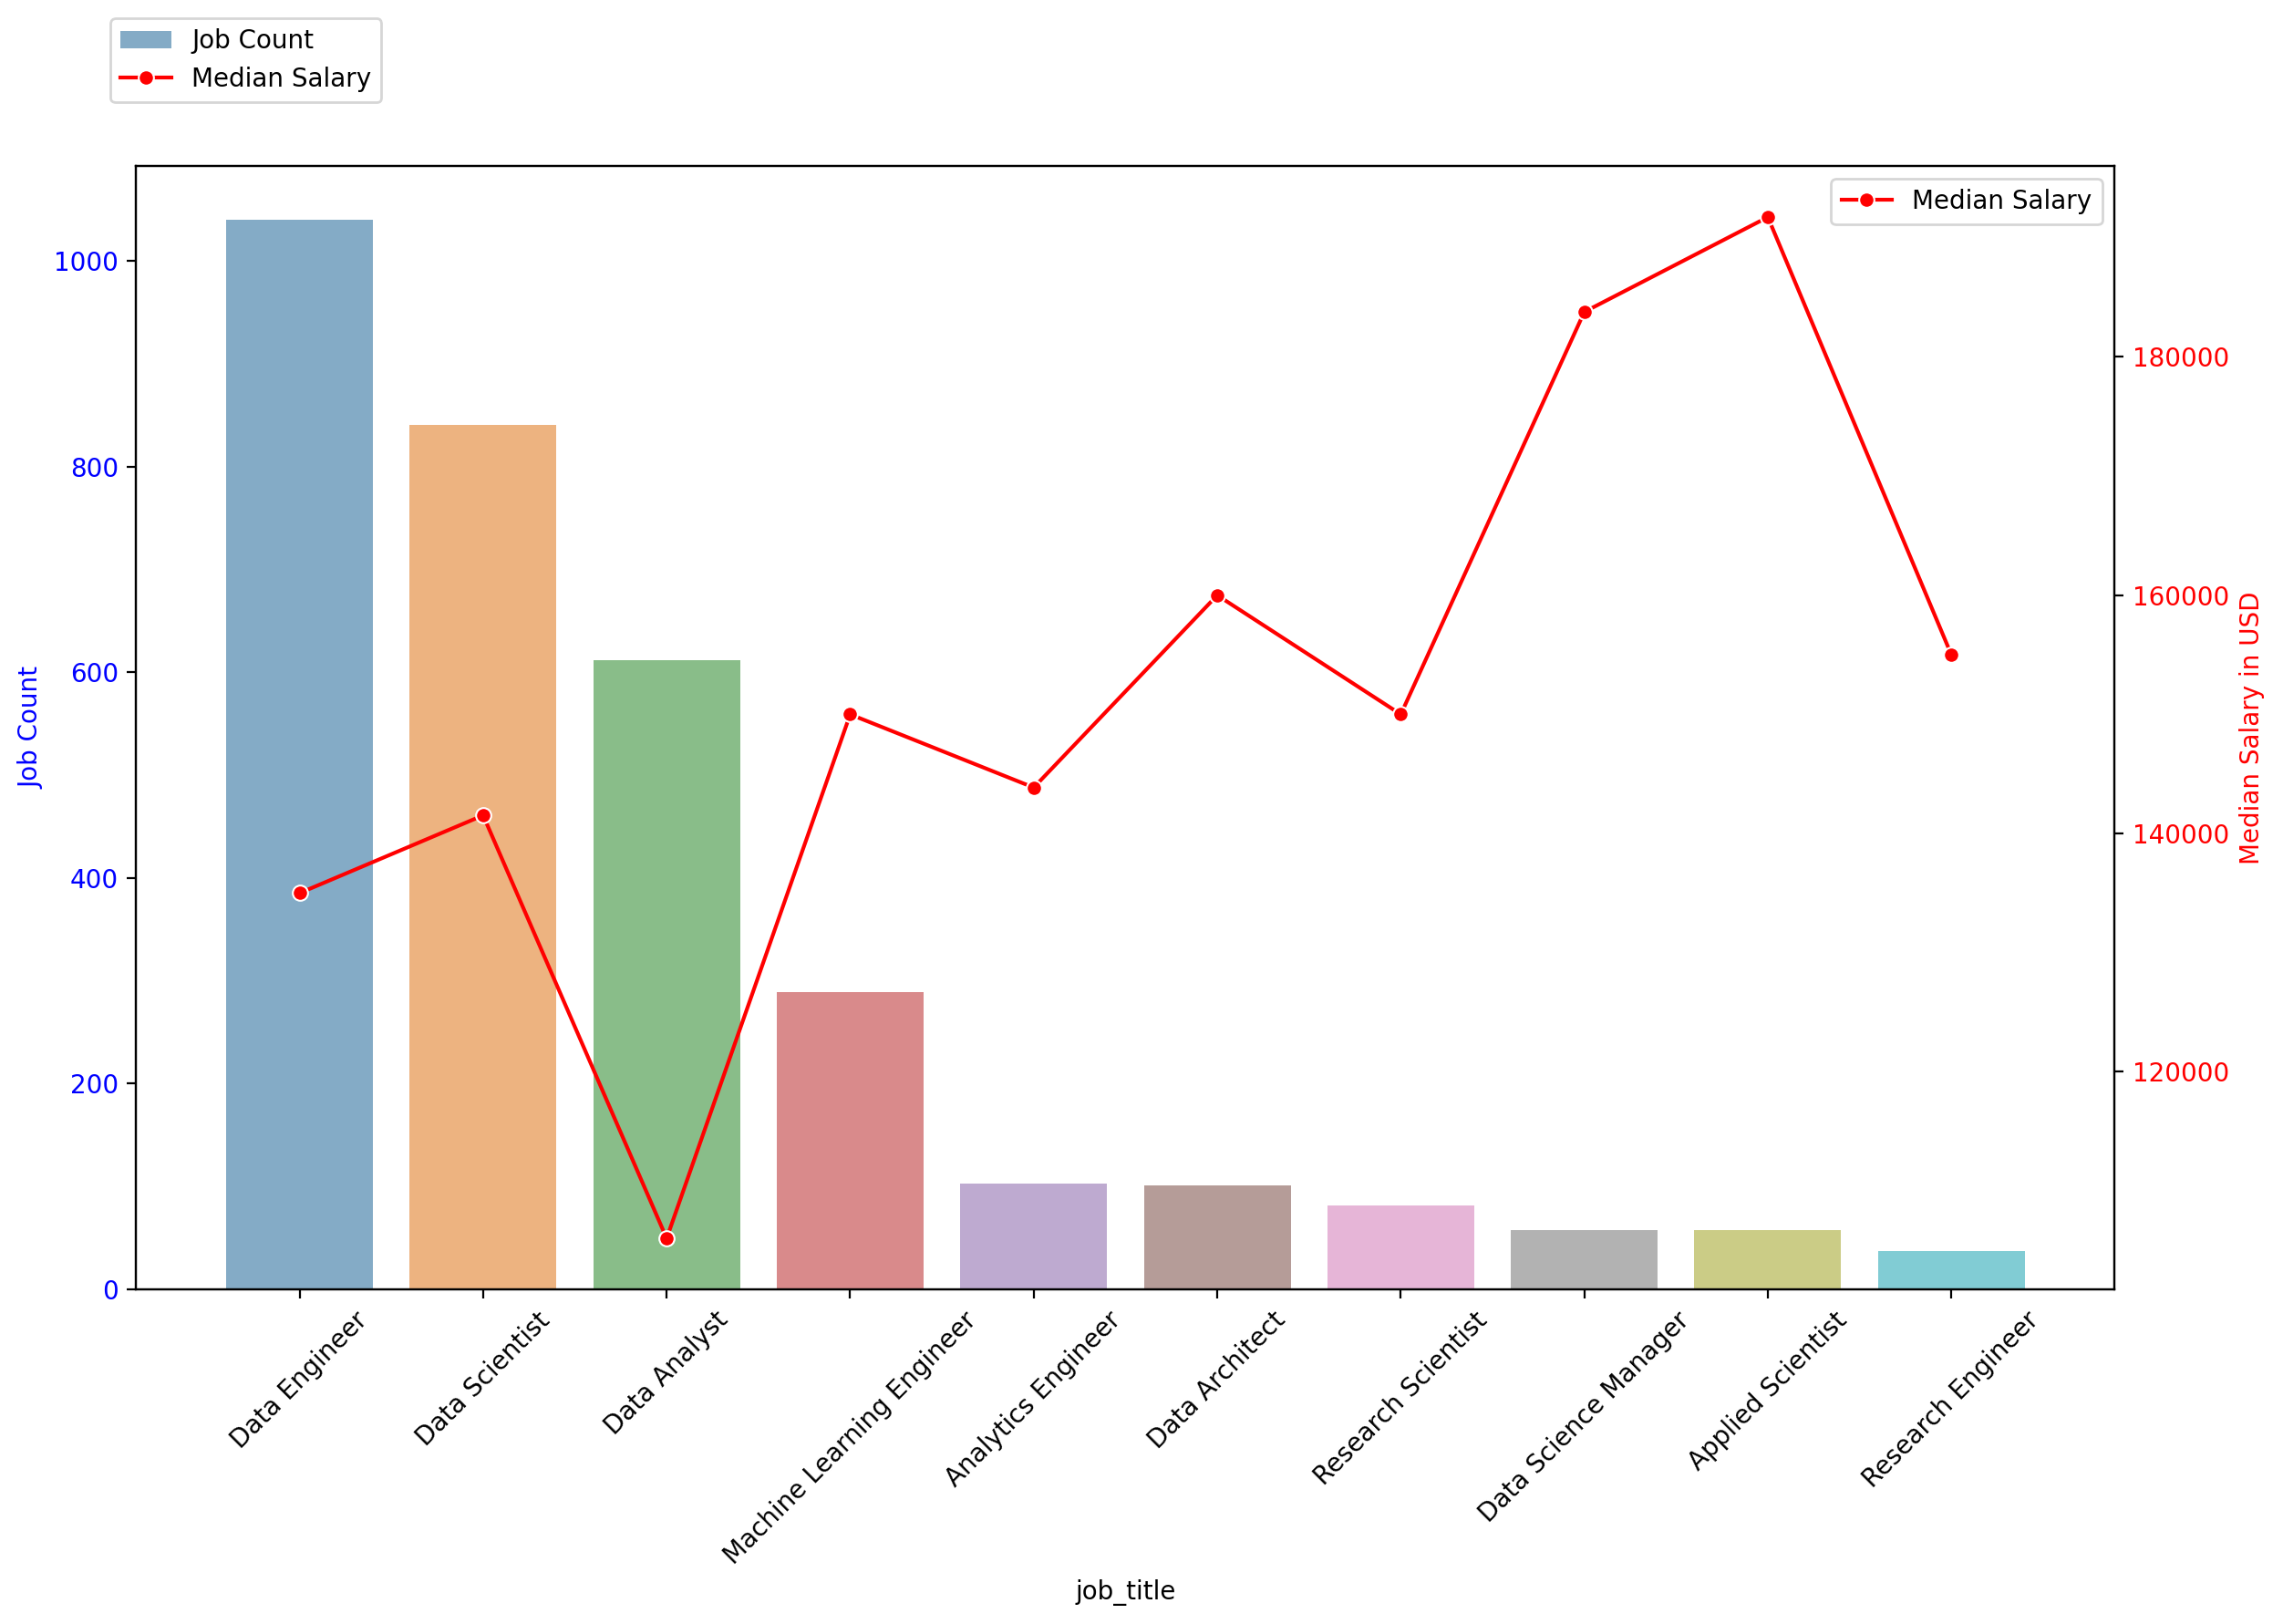

In [12]:
# Counting the occurrences of each job title to find the top 10 most common job titles
top_10_job_titles = df['job_title'].value_counts().nlargest(10).reset_index()
top_10_job_titles.columns = ['job_title', 'count']
median_salary_by_job_title = df[df['job_title'].isin(top_10_job_titles['job_title'])].groupby('job_title')['salary_in_usd'].median().reset_index()
top_10_job_titles_with_salary = pd.merge(top_10_job_titles, median_salary_by_job_title, on='job_title').sort_values('count', ascending=False)


fig, ax1 = plt.subplots(figsize=(14, 8), dpi=200)
sns.barplot(x='job_title', y='count', data=top_10_job_titles_with_salary, ax=ax1, alpha=0.6, label='Job Count')
ax1.set_ylabel('Job Count', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

# plot the median salary
ax2 = ax1.twinx()
sns.lineplot(x='job_title', y='salary_in_usd', data=top_10_job_titles_with_salary, ax=ax2, color='r', marker='o', label='Median Salary')
ax2.set_ylabel('Median Salary in USD', color='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(loc="upper left", bbox_to_anchor=(0.11,0.99))




* Data Engineer: 1,040 occurrences, Median Salary: 135,000  
* Data Scientist: 840 occurrences, Median Salary: 141,525  
* Data Analyst: 612 occurrences, Median Salary: 106,020  
* Machine Learning Engineer: 289 occurrences, Median Salary: 150,000  
* Analytics Engineer: 103 occurrences, Median Salary: 143,860  
* Data Architect: 101 occurrences, Median Salary: 160,000  
* Research Scientist: 82 occurrences, Median Salary: 150,000  
* Data Science Manager: 58 occurrences, Median Salary: 183,780  
* Applied Scientist: 58 occurrences, Median Salary: 191,737.5  
* Research Engineer: 37 occurrences, Median Salary: 155,000  

**The blue bars represent the number of occurrences of each job title, while the red line plot indicates the median salary for each of these top 10 job titles.**

#### Let's explore more! 
1. Experience Level vs Region: How does the experience level distribution vary by region?
1. Company Size vs Job Title: Do certain job titles tend to appear more frequently in companies of a certain size?
1. Remote Ratio vs Experience Level: Does the opportunity for remote work vary with experience level?

In [13]:
top_5_region = df['employee_residence'].value_counts().nlargest(5).reset_index()
top_5_region_df = df[df['employee_residence'].isin(top_5_region['employee_residence'])]

In [14]:
top_10_job_titles['job_title'].tolist()

['Data Engineer',
 'Data Scientist',
 'Data Analyst',
 'Machine Learning Engineer',
 'Analytics Engineer',
 'Data Architect',
 'Research Scientist',
 'Data Science Manager',
 'Applied Scientist',
 'Research Engineer']

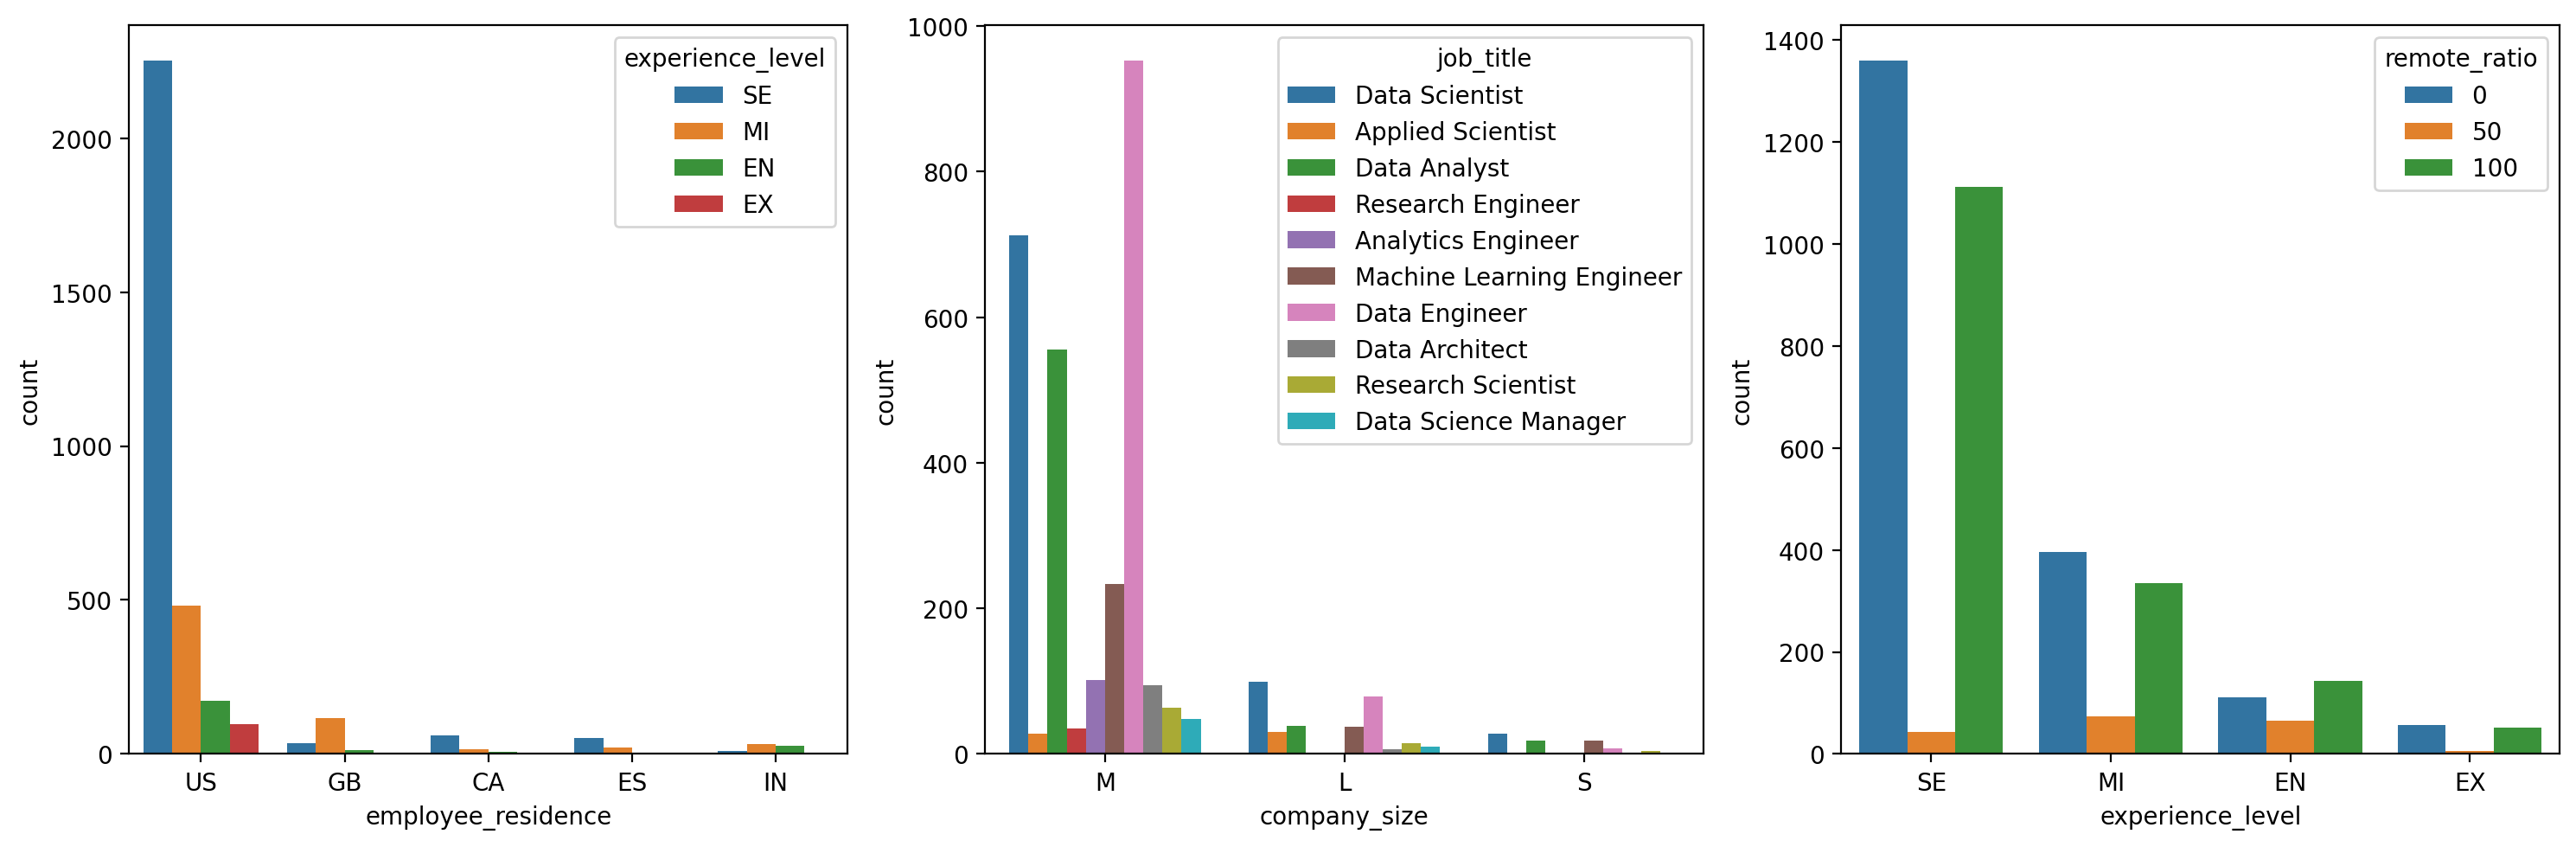

In [15]:
fig, ax = plt.subplots(1,3, figsize=(15,5), dpi=200)
sns.countplot(ax=ax[0], x='employee_residence', hue='experience_level', data=df, order=top_5_region['employee_residence'].tolist())
sns.countplot(ax=ax[1], x='company_size', hue='job_title', data=df[df['job_title'].isin(top_10_job_titles['job_title'].tolist())])
sns.countplot(ax=ax[2], data=df, x='experience_level', hue='remote_ratio')
plt.tight_layout()

**Experience Level Distribution by Top 10 Regions:** The first plot shows the distribution of experience levels in the top 10 regions based on the count of job entries. You can see how experience levels vary across different regions.

**Company Size vs Top 10 Job Titles:** The second plot reveals the frequency of the top 10 job titles in companies of different sizes. This can help you understand if certain job titles are more common in small, medium, or large companies.

**Remote Ratio vs Experience Level:** The third plot shows the distribution of the remote work ratio across different experience levels. This can indicate whether remote work opportunities vary depending on experience level.

In [73]:
# salary in region
country = coco.convert(names = df['employee_residence'], to = "ISO3")
df['employee_residence'] = country
avg_salary = df.groupby('employee_residence')['salary_in_usd'].mean().reset_index()
fig = px.choropleth(avg_salary, 
                    locations='employee_residence', 
                    color='salary_in_usd',
                    hover_name='employee_residence',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=[10000, 100000],
                    locationmode='ISO-3')
fig.show()

In [ ]:
# # salary in region
country = coco.convert(names = df['employee_residence'], to = "ISO3")
df['employee_residence'] = country
avg_salary = df.groupby('employee_residence')['salary_in_usd'].mean().reset_index()
fig = px.choropleth(avg_salary, 
                    locations='employee_residence', 
                    color='salary_in_usd',
                    hover_name='employee_residence',
                    color_continuous_scale=px.colors.sequential.Plasma,
                    range_color=[10000, 100000],
                    locationmode='ISO-3')
fig.show()

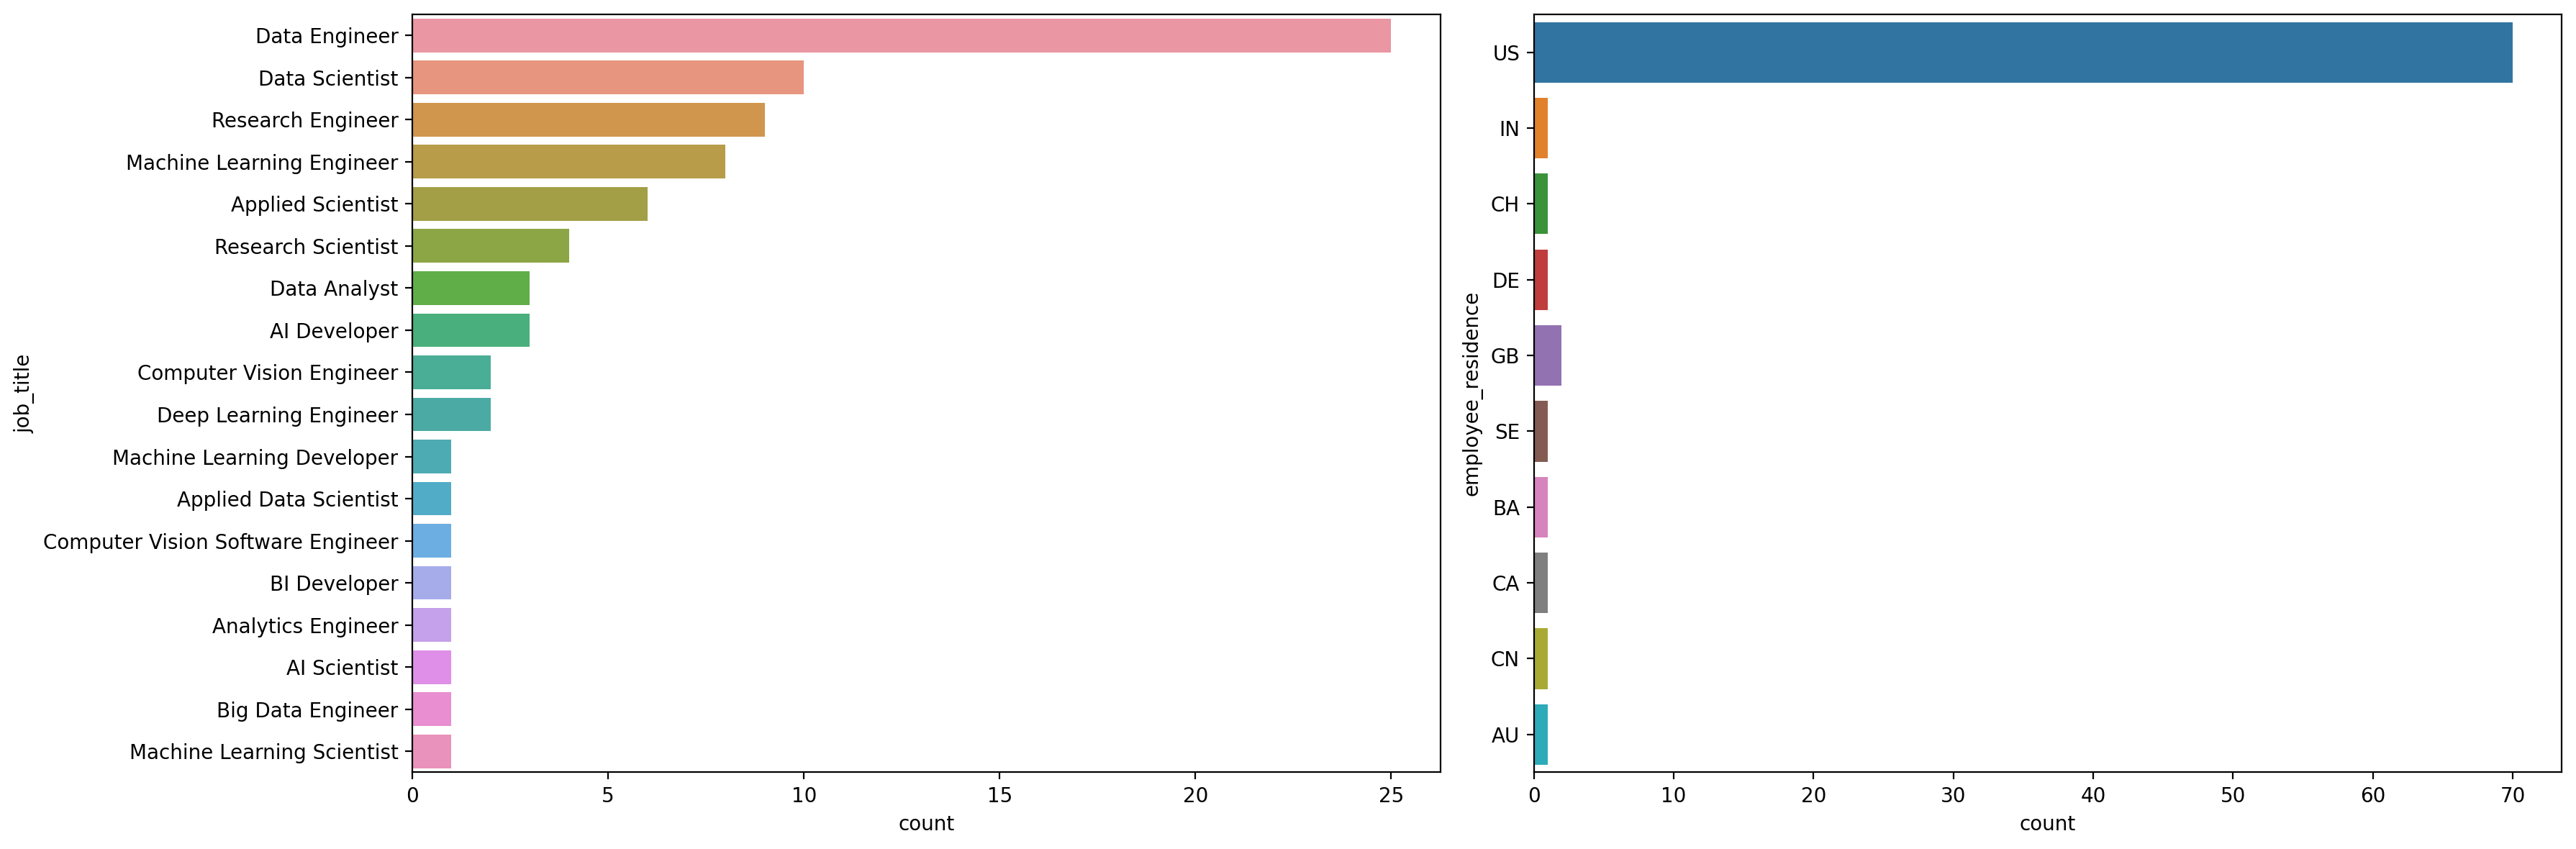

In [16]:
# get the info of entry level and have the top 25% salary
entry_df = df[df['experience_level'] == 'EN']
entry_df_25 = entry_df[entry_df['salary_in_usd'] >= entry_df['salary_in_usd'].quantile(0.75)]
job_title_order = entry_df_25['job_title'].value_counts().index
fig, ax = plt.subplots(1,2, figsize=(18,6), dpi=200)
sns.countplot(entry_df_25, y='job_title', order=job_title_order, ax=ax[0])
sns.countplot(entry_df_25, y='employee_residence', ax=ax[1])
plt.tight_layout()

**Most Common Job Titles:**  
Data Engineer: 25 occurrences  
Data Scientist: 10 occurrences  
Research Engineer: 9 occurrences  
Machine Learning Engineer: 8 occurrences  
Applied Scientist: 6 occurrences  
**Most Common Regions:**  
United States (US): 70 occurrences  
United Kingdom (GB): 2 occurrences  
India (IN): 1 occurrence  

In [17]:
# create model to predict
features = ['experience_level','employment_type','job_title','salary_currency','employee_residence','remote_ratio','company_location','company_size']
X = df[features]
y = df['salary_in_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [18]:
train_pool = Pool(X_train, label=y_train, cat_features=features)
test_pool = Pool(X_test, label=y_test, cat_features=features)
cat = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=4, cat_features=features, verbose=200)
grid = {
    'depth':[4,6,8],
    'learning_rate':[0.01,0.03,0.1]
}
cat.grid_search(grid, train_pool, verbose=200, plot=False, refit=True)
y_pred = cat.predict(test_pool)

0:	learn: 149373.9338090	test: 153832.6033184	best: 153832.6033184 (0)	total: 59.6ms	remaining: 59.5s
200:	learn: 56064.5647059	test: 55625.8605261	best: 55625.8605261 (200)	total: 684ms	remaining: 2.72s
400:	learn: 49255.9634058	test: 48826.0855749	best: 48826.0855749 (400)	total: 1.31s	remaining: 1.96s
600:	learn: 48323.8949581	test: 48275.7986364	best: 48275.7986364 (600)	total: 2.06s	remaining: 1.37s
800:	learn: 47769.8087591	test: 48091.8413319	best: 48091.8413319 (800)	total: 2.8s	remaining: 695ms
999:	learn: 47296.4225869	test: 47979.3918634	best: 47979.3827114 (998)	total: 3.7s	remaining: 0us

bestTest = 47979.38271
bestIteration = 998

0:	loss: 47979.3827114	best: 47979.3827114 (0)	total: 3.77s	remaining: 30.1s
0:	learn: 146842.7793481	test: 151231.0596404	best: 151231.0596404 (0)	total: 3.52ms	remaining: 3.51s
200:	learn: 48372.8771424	test: 48305.1266261	best: 48304.0921398 (194)	total: 584ms	remaining: 2.32s
400:	learn: 47041.4070668	test: 47824.3554124	best: 47821.1427690 

In [37]:
print('Depth:', cat.get_all_params()['depth'])
print('Learning Rate:',cat.get_all_params()['learning_rate'])

Depth: 8
Learning Rate: 0.029999999329447743


In [29]:
imp = cat.get_feature_importance()
pd.DataFrame(imp, index=features, columns=['Importance'])

,Importance
experience_level,16.772174
employment_type,4.785188
job_title,28.412489
salary_currency,14.998989
employee_residence,12.586812
remote_ratio,10.617962
company_location,3.189531
company_size,8.636855


In [19]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
salary_std = y_test.std()
rmse/salary_std

0.7687923613902233

In [20]:
salary_std

62985.1910818705